In [2]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import string

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


Text(0.5, 1.0, 'CRTL')

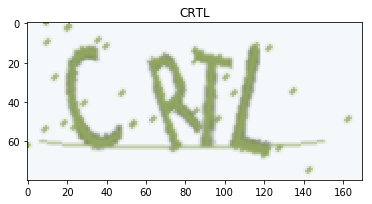

In [10]:
characters = string.digits + string.ascii_uppercase
print(character)
width, height , n_len , n_class = 170, 80 , 4 , len(character)+1
generator = ImageCaptcha(width  =  width , height = height)

random_str = ''.join([random.choice(character) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)

In [11]:
from keras import backend as K
import keras

##CTC Loss需要四個資訊，分別是
## Label
## 預測
## CNN OUTPUT寬度
## 預測影像所包含文字長度

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [12]:
from keras.models import *
from keras.layers import *
rnn_size = 128

input_tensor = Input((height,width,3))
x = input_tensor

'''自己設計CNN層'''
x = Conv2D(32 , (3,3) , padding = 'same' , activation = 'relu')(input_tensor)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2),strides = (2,2))(x)

x = Conv2D(64,(3,3) , padding = 'same' , activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2) , strides = (2,2,))(x)

x = Conv2D(128 , (3,3) , padding = 'same' , activation = 'relu')(input_tensor)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2),strides = (2,2))(x)

x = Conv2D(128,(3,3) , padding = 'same' , activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2) , strides = (2,2,))(x)

##記錄輸出CNN尺寸，loss部分需要這個資訊
##conv_shape=(Batch_size,輸出高度,輸出寬度,輸出深度)
conv_shape = x.get_shape()

##從(Batch_size,輸出高度,輸出寬度,輸出深度)變成(Batch_size,輸出寬度,輸出深度*輸出高度)，以符合ctc loss需求
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)

x = Dense(32,activation = 'relu')(x)
x = Dropout(0.25)(x)
x = Dense(n_class,activation ='softmax')(x)

##包裝用來預測的model
base_model = Model(input=input_tensor, output=x)


##設定要給CTC Loss的資訊
labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

##這裡的model是用來計算loss
model = Model(input=[input_tensor, labels, input_length, label_length], output=[loss_out])

##之所以要lambda y_true, y_pred: y_pred是因為我們的loss已經包在網路裡，會output:y_true, y_pred，而我們只需要y_pred
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='SGD')

D:\ACA\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
D:\ACA\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [40]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 80, 170, 128) 3584        input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_35 (BatchNo (None, 80, 170, 128) 512         conv2d_36[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_34 (MaxPooling2D) (None, 40, 85, 128)  0           batch_normalization_35[0][0]     
__________________________________________________________________________________________________
conv2d_37 

In [13]:
from keras import backend as K
import keras

##CTC Loss需要四個資訊，分別是
## Label
## 預測
## CNN OUTPUT寬度
## 預測影像所包含文字長度
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [14]:
##設計generator產生training data
## 產生包含要給loss的資訊
## X=輸入影像
## np.ones(batch_size)*int(conv_shape[2])=CNN輸出feature Map寬度
## np.ones(batch_size)*n_len=字串長度(可浮動)

def gen(batch_size=128):
    X = np.zeros((batch_size,height, width, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        generator = ImageCaptcha(width=width, height=height)
        for i in range(batch_size):
            random_str = ''.join([random.choice(character) for j in range(4)])
            X[i] = np.array(generator.generate_image(random_str))
            y[i] = [character.find(x) for x in random_str]
        yield [X, y,np.ones(batch_size)*int(conv_shape[2]), np.ones(batch_size)*n_len], np.ones(batch_size)

Label:  [[25  4 14 19]]
CNN輸出寬度:  [42.]
字串長度(可浮動):  [4.]


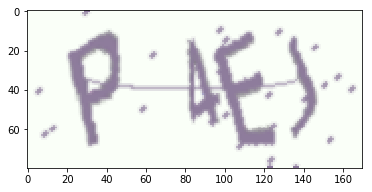

In [8]:
next_ge=gen(batch_size=1)
test_ge=next(next_ge)
plt.imshow(test_ge[0][0][0])
print('Label: ',test_ge[0][1])
print('CNN輸出寬度: ',test_ge[0][2])
print('字串長度(可浮動): ',test_ge[0][3])

In [44]:
model.fit_generator(gen(32), steps_per_epoch=300, epochs=60)

Epoch 1/60
300/300 [==============================] - 652s 2s/step - loss: 16.6891
Epoch 2/60
300/300 [==============================] - 654s 2s/step - loss: 15.4976
Epoch 3/60
300/300 [==============================] - 615s 2s/step - loss: 15.2510
Epoch 4/60
300/300 [==============================] - 600s 2s/step - loss: 15.1521
Epoch 5/60
300/300 [==============================] - 588s 2s/step - loss: 15.1063
Epoch 6/60
300/300 [==============================] - 591s 2s/step - loss: 15.0774
Epoch 7/60
300/300 [==============================] - 586s 2s/step - loss: 15.0511
Epoch 8/60
300/300 [==============================] - 597s 2s/step - loss: 15.0323
Epoch 9/60
300/300 [==============================] - 659s 2s/step - loss: 15.0300
Epoch 10/60
300/300 [==============================] - 627s 2s/step - loss: 15.0056
Epoch 11/60
300/300 [==============================] - 605s 2s/step - loss: 14.9894
Epoch 12/60
300/300 [==============================] - 624s 2s/step - loss: 14.9478
E

KeyboardInterrupt: 

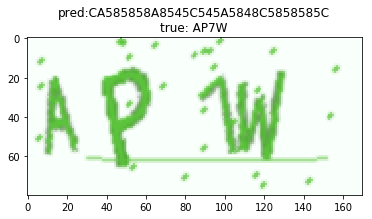

In [16]:
characters2 = characters + ' '
[X_test, y_test, _, _], _  = next(gen(1))
y_pred = base_model.predict(X_test)
##用ctc_decode得到解答，自己寫可以參考下方
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0])
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]